# Академия MADE
## Курс компьютерного зрения
### Семинар 2: реализация ResNet

#### План
1. (Recap) Рутина обучения в PyTorch
2. Реализация простой сети типа ResNet
3. Проверка эффекта от BatchNormalization
4. Проверка эффекта от residual-блоков
5. ДЗ для любознательных

In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.optim import Adam
from torch.nn.functional import cross_entropy, relu

from utils import plot, show_kernels

In [2]:
# MNIST: 1x28x28
DATASET = "MNIST"

# CIFAR10: 3x32x32
# DATASET = "CIFAR10"

# DEVICE = "cpu"
DEVICE = "cuda:0"

NUM_EPOCHS = 2
BATCH_SIZE = 256
LR = 3e-4

Получим данные

In [3]:
transforms = Compose([
    ToTensor(),
    Normalize(0.5, 0.25, inplace=True),
])

if DATASET == "MNIST":
    IMAGE_CHANNELS = 1
    NUM_CLASSES = 10
    dataset = MNIST("./dataset/mnist", download=True, transform=transforms)
elif DATASET == "CIFAR10":
    IMAGE_CHANNELS = 3
    NUM_CLASSES = 10
    dataset = CIFAR10("./dataset/cifar", download=True, transform=transforms)
else:
    raise NotImplementedError(DATASET)

#### (Recap) Рутина обучения в PyTorch

In [4]:
def train(model, dataset=dataset, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, lr=LR, device=DEVICE):
    """Model training routine function. 
    Uses Adam optimizer & cross-entropy loss.
    
    Args:
        model: torch.nn.Module
        dataset: torch.utils.data.Dataset
        num_epochs: int
        batch_size: int
        lr: float
        device: str
        
    Returns:
        losses: list of float values of length num_epochs * len(dataloader)
    """
    model.train()
    model = model.to(device)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True, pin_memory=True)
    optimizer = Adam(model.parameters(), lr=lr)
    
    losses = []    
    for epoch in range(num_epochs):
        for batch in tqdm.tqdm(dataloader):
            xs, ys_true = batch
            
            logits_pred = model(xs.to(device))#.to("cpu")
            loss = cross_entropy(logits_pred, ys_true.to(device))
            
            # optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                                
            losses.append(loss.cpu().item())
    
    return losses

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 28.50it/s]


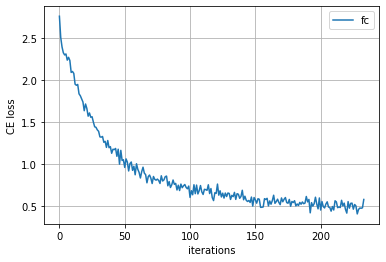

In [5]:
# TESTS for train()

input_size = dataset[0][0].size()
fc = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(np.prod(input_size), NUM_CLASSES)
)
losses_fc = train(fc, dataset, num_epochs=1)

assert len(losses_fc) == len(dataset) // BATCH_SIZE
assert np.mean(losses_fc[:10]) > np.mean(losses_fc[-10:])

plot(losses_fc, "fc")

#### Реализация простой сети типа ResNet

Взглянем на примерную схему сети ResNet34:

![resnet34](res/resnet34.png)

Реализуем свой "ResNet10":

![resnet10](res/resnet10.png)

Пересчитайте число слоев с весами - их как раз 10.

Кроме того, для простоты все операции уменьшения размера сведем к пулингу и вынесем в отдельные слои (а не встроим в сами сверточные блоки, как, например, в [torchvision](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)).

Для начала реализуем вспомогательную функцию `get_conv(...)`, которая приготовит нам последовательность (свертка + активация + батчнорм). Это очень распространенная комбинация операций, которая на будет нужна неоднократно:

In [27]:
def get_conv(kernel_size, in_features, out_features, with_bn=True, with_relu=True):
    """Create conv -> [relu] -> [bn] layers, embedded in torch.nn.Sequential module.
    
    ! Conv layer must preserve spatial tensor dims (i.e. apply zero padding).
    
    Args:
        kernel_size: int
        in_features: int
        out_features: int
        with_bn: bool
        with_relu: bool
        
    Returns:
        torch.nn.Sequential
    """
    layers = [
        nn.Conv2d(in_features, out_features, kernel_size, stride=1, padding=kernel_size//2)
    ]
    
    if with_relu:
        layers.append(nn.ReLU(inplace=with_bn))
        
    if with_bn:
        layers.append(nn.BatchNorm2d(out_features))
    
    return nn.Sequential(*layers)

In [28]:
# TESTS for get_conv()
conv = get_conv(3, 8, 16)

assert len(conv) == 3
assert isinstance(conv[0], torch.nn.Conv2d)
assert conv[0].in_channels == 8
assert conv[0].out_channels == 16

assert isinstance(conv[1], torch.nn.ReLU)

assert isinstance(conv[2], torch.nn.BatchNorm2d)
assert conv[2].num_features == 16


conv = get_conv(3, 8, 16, with_bn=False, with_relu=False)

assert len(conv) == 1
assert isinstance(conv[0], torch.nn.Conv2d)
assert conv[0].in_channels == 8
assert conv[0].out_channels == 16

Также реализуем слой `GlobalAveragePooling`. Помните, зачем он нужен?

In [29]:
class GlobalAveragePooling2d(nn.Module):
    def forward(self, x):
        """GAP forward pass.
        
        Args:
            x: torch.Tensor, size B x C x H x W.
        
        Returns:
            torch.Tensor, size B x C.
        """
        y = torch.mean(x, dim=(2, 3))
        return y

In [30]:
# TESTS for GAP

gap = GlobalAveragePooling2d()
x = torch.randn(4, 3, 16, 16)
y = gap(x)

assert y.size() == (4, 3)

Перейдем к главному в ResNet - собственно, residual-блоку:

![residual_block](res/residual_block.png)

Под "блоком" мы будем иметь в виду последовательность сверточных слоев (с активацией и BN), "вокруг" которых прокинут skip-connection. Таким образом, в нашей сети "ResNet10" будет 4 таких блока (найдите их на картинке c ResNet10 выше).

Важный момент: обратите внимание, что тензоры **x** и **F(x)** могут иметь разное число каналов (например, 64 и 128). Как же сложить два таких тензора?..

Ответ: сделать "проекцию", см. `projection` в коде.

In [31]:
class ResidualBlock(nn.Module):
    def __init__(self, num_input_features, num_features, num_layers, with_bn=True):
        super().__init__()
        
        if num_input_features != num_features:
            self.projection = nn.Conv2d(num_input_features, num_features, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        else:
            self.projection = None
        
        layers = []
        for i in range(num_layers):
            conv = get_conv(3, num_input_features, num_features, with_bn=with_bn)
            layers.append(conv)
            num_input_features = num_features
        self.layers = nn.Sequential(*layers)
        
        self.num_input_features = num_input_features
        self.num_features = num_features
        self.num_layers = num_layers
        self.with_bn = with_bn
        
    def forward(self, x):
        """Forward pass.
        Applies convolution layers and skip-connection; self.projection, if necessary.
        
        Args:
            x: torch.Tensor, size B x C x H x W.
            
        Returns:
            torch.Tensor, size B x C x H x W.
        """
        x_input = x
        
        for layer in self.layers:
            x = layer(x)
        
        if self.projection is not None:
            x_input = self.projection(x_input)
        
        x += x_input
        return relu(x)
    
    def __repr__(self):
        out = f"ResidualBlock(num_input_features={self.num_input_features}, num_features={self.num_features}, num_layers={self.num_layers}, with_bn={self.with_bn})"
        for l in self.layers:
            out += "\n" + "\t" + repr(l)
        return out

In [32]:
# TESTS for ResidualBlock
block = ResidualBlock(4, 4, 2)

assert len(block.layers) == 2
assert len(block.layers[0]) == 3
assert len(block.layers[1]) == 3
assert isinstance(block.layers[1][2], nn.BatchNorm2d)

print(block)

ResidualBlock(num_input_features=4, num_features=4, num_layers=2, with_bn=True)
	Sequential(
  (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
	Sequential(
  (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Дальше дело за малым - собрать из готовых блоков нашу сеть:

![resnet10](res/resnet10.png)


In [33]:
def create_resnet10(num_input_features=IMAGE_CHANNELS, num_classes=NUM_CLASSES, with_bn=True):
    pool = nn.MaxPool2d((2, 2))
    gap = GlobalAveragePooling2d()
    fc = nn.Linear(512, num_classes)
    
    return nn.Sequential(
        get_conv(7, num_input_features, 64, with_bn=with_bn),
        pool,
        ResidualBlock(64, 64, 2, with_bn=with_bn),
        pool,
        ResidualBlock(64, 128, 2, with_bn=with_bn),
        pool,
        ResidualBlock(128, 256, 2, with_bn=with_bn),
        pool,
        ResidualBlock(256, 512, 2, with_bn=with_bn),
        gap,
        fc
    )

In [34]:
resnet10 = create_resnet10()
resnet10;

Обучим полученную модель с помощью реализованной в начале функции `train()`:

In [35]:
losses_resnet10 = train(resnet10)

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:15<00:00, 15.07it/s]


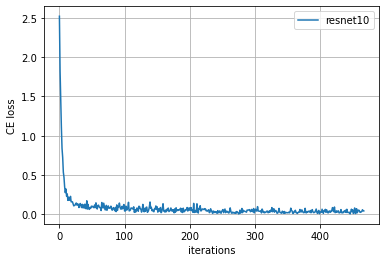

In [36]:
plot(losses_resnet10, label="resnet10")

#### Проверка эффекта от BatchNormalization


Теперь проведем небольшой эксперимент: создадим сеть с аналогичной нашему ResNet10 архитектурой, но без слоев BatchNormalization.

In [37]:
resnet10_nobn = create_resnet10(with_bn=False)

In [38]:
losses_resnet10_nobn = train(resnet10_nobn)

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:14<00:00, 16.63it/s]


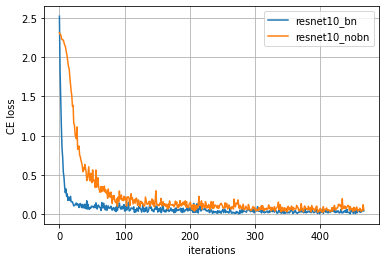

In [39]:
plot(losses_resnet10, label="resnet10_bn")
plot(losses_resnet10_nobn, label="resnet10_nobn")

#### Проверка эффекта от Residual-блоков


Теперь построим модель, у которой будет аналогичное число параметров (и FLOPS), но у которой не будет skip-connections. Называться она будет... Net10?

Для этого напишем класс для обычного блока - это легко сделать, ощипав уже написанный класс `ResidualBlock` (да, все вот так наоборот).

In [40]:
class Block(nn.Module):
    def __init__(self, num_input_features, num_features, num_layers, with_bn=True):
        super().__init__()

        layers = []
        for i in range(num_layers):
            conv = get_conv(3, num_input_features, num_features, with_bn=with_bn)
            layers.append(conv)
            num_input_features = num_features
        self.layers = nn.Sequential(*layers)

        self.num_input_features = num_input_features
        self.num_features = num_features
        self.num_layers = num_layers
        self.with_bn = with_bn

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        out = f"Block(num_input_features={self.num_input_features}, num_features={self.num_features}, num_layers={self.num_layers}, with_bn={self.with_bn})"
        for l in self.layers:
            out += "\n" + "\t" + repr(l)
        return out

Функция для создания модели - тоже аналогична:

In [41]:
def create_net10(num_input_features=IMAGE_CHANNELS, num_classes=NUM_CLASSES, with_bn=True):
    pool = nn.MaxPool2d((2, 2))
    gap = GlobalAveragePooling2d()
    fc = nn.Linear(512, num_classes)
    return nn.Sequential(
        get_conv(7, num_input_features, 64, with_bn=with_bn),
        pool,
        Block(64, 64, 2, with_bn=with_bn),
        pool,
        Block(64, 128, 2, with_bn=with_bn),
        pool,
        Block(128, 256, 2, with_bn=with_bn),
        pool,
        Block(256, 512, 2, with_bn=with_bn),
        gap,
        fc
    )

In [44]:
net10 = create_net10()
net10;

In [45]:
losses_net10 = train(net10)

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:14<00:00, 15.87it/s]


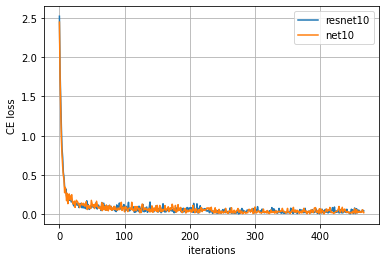

In [46]:
plot(losses_resnet10, label="resnet10")
plot(losses_net10, label="net10")

При обучении данных моделей разницы почти не видно... Почему?

Ок, сделаем сети поглубже:

In [47]:
def create_net34(num_input_features=IMAGE_CHANNELS, num_classes=NUM_CLASSES, with_bn=True):
    pool = nn.MaxPool2d((2, 2))
    gap = GlobalAveragePooling2d()
    fc = nn.Linear(512, num_classes)
    return nn.Sequential(
        get_conv(7, num_input_features, 64, with_bn=with_bn),
        pool,
        Block(64, 64, 2, with_bn=with_bn),
        Block(64, 64, 2, with_bn=with_bn),
        Block(64, 64, 2, with_bn=with_bn),
        pool,
        Block(64, 128, 2, with_bn=with_bn),
        Block(128, 128, 2, with_bn=with_bn),
        Block(128, 128, 2, with_bn=with_bn),
        pool,
        Block(128, 256, 2, with_bn=with_bn),
        Block(256, 256, 2, with_bn=with_bn),
        Block(256, 256, 2, with_bn=with_bn),
        Block(256, 256, 2, with_bn=with_bn),
        Block(256, 256, 2, with_bn=with_bn),
        pool,
        Block(256, 512, 2, with_bn=with_bn),
        Block(512, 512, 2, with_bn=with_bn),
        Block(512, 512, 2, with_bn=with_bn),
        gap,
        fc
    )

In [48]:
def create_resnet34(num_input_features=IMAGE_CHANNELS, num_classes=NUM_CLASSES, with_bn=True):
    pool = nn.MaxPool2d((2, 2))
    gap = GlobalAveragePooling2d()
    fc = nn.Linear(512, num_classes)
    return nn.Sequential(
        get_conv(7, num_input_features, 64, with_bn=with_bn),
        pool,
        ResidualBlock(64, 64, 2, with_bn=with_bn),
        ResidualBlock(64, 64, 2, with_bn=with_bn),
        ResidualBlock(64, 64, 2, with_bn=with_bn),
        pool,
        ResidualBlock(64, 128, 2, with_bn=with_bn),
        ResidualBlock(128, 128, 2, with_bn=with_bn),
        ResidualBlock(128, 128, 2, with_bn=with_bn),
        pool,
        ResidualBlock(128, 256, 2, with_bn=with_bn),
        ResidualBlock(256, 256, 2, with_bn=with_bn),
        ResidualBlock(256, 256, 2, with_bn=with_bn),
        ResidualBlock(256, 256, 2, with_bn=with_bn),
        ResidualBlock(256, 256, 2, with_bn=with_bn),
        pool,
        ResidualBlock(256, 512, 2, with_bn=with_bn),
        ResidualBlock(512, 512, 2, with_bn=with_bn),
        ResidualBlock(512, 512, 2, with_bn=with_bn),
        gap,
        fc
    )

In [49]:
net34 = create_net34()
net34;

In [50]:
losses_net34 = train(net34)

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:29<00:00,  8.02it/s]


In [51]:
resnet34 = create_resnet34()
resnet34;

In [52]:
losses_resnet34 = train(resnet34)

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:30<00:00,  7.67it/s]


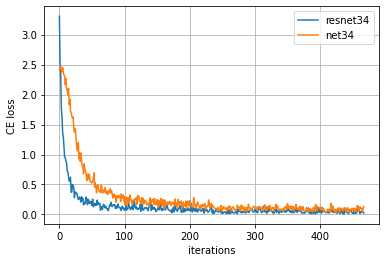

In [53]:
plot(losses_resnet34, "resnet34")
plot(losses_net34, "net34")

Gotcha!

#### (Bonus) Свертки первого слоя

Возьмем ResNet18, предобученный (долго и качественно, в отличие от наших поделок) на датасете ImageNet и отрисуем ядра сверток первого сверточного слоя:

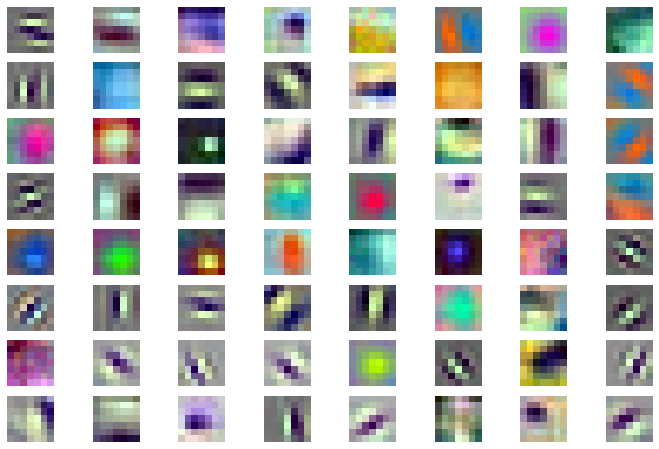

In [54]:
from torchvision.models import resnet18

resnet18_pt = resnet18(pretrained=True)
show_kernels(resnet18_pt.conv1)

#### Для любознательных

* Поучите сети подольше. Как соотносятся итоговые результаты с residual-блоками и без? С BN и без?
* Мы замеряли только train loss. Попробуйте замерить другие метрики, использовать validation set, ...
* Реализуйте SEBlock (Squeeze-n-Excitation), а затем соберите (с помощью кода из этого семинара) SE-Net. Как она себя ведет?
* Реализуйте Bottleneck для ResNet50/101/152. Подсмотреть можно [тут](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).